In [1]:
import warnings

from collections import OrderedDict
import functools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
# use ggplot styles for graphs
plt.style.use('ggplot')

import arviz as az
warnings.filterwarnings("ignore")
warnings.simplefilter('ignore')

In [2]:
import tensorflow as tf
import tensorflow_probability as tfp
import pymc3 as pm

# set tf logger to log level ERROR to avoid warnings
tf.get_logger().setLevel('ERROR')

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

In [3]:
# import probabilistic models
from bayes_vi.models import Model

# import utils
from bayes_vi.utils.datasets import make_dataset_from_df

In [4]:
# mcmc imports
from bayes_vi.inference.mcmc import MCMC
from bayes_vi.inference.mcmc.transition_kernels import HamiltonianMonteCarlo, NoUTurnSampler, RandomWalkMetropolis
from bayes_vi.inference.mcmc.stepsize_adaptation_kernels import SimpleStepSizeAdaptation, DualAveragingStepSizeAdaptation

In [6]:
# vi imports 
from bayes_vi.inference.vi import VI

from bayes_vi.inference.vi.surrogate_posteriors import ADVI, NormalizingFlow
from bayes_vi.utils import to_ordered_dict
from bayes_vi.inference.vi.flow_bijectors import HamiltonianFlow, AffineFlow, make_energy_fn, make_scale_fn, make_shift_fn
from bayes_vi.utils.leapfrog_integrator import LeapfrogIntegrator

# Univariate Mixture of Gaussians

## 1. Generate Test Data

In [7]:
# generate parameters for the "true" underlying mixture model
num_datapoints = 50

true_component_n = np.random.choice(a=list(range(2,4+1)))

true_locs = tf.constant(np.random.choice(a=list(range(-20,20+1)), size=true_component_n), dtype=tf.float32)

true_scales = tf.constant(np.random.choice(a=list(range(1, 5+1)), size=true_component_n), dtype=tf.float32)

selected_component = np.random.randint(0, true_component_n, 50)
true_component_weights = tf.constant(np.histogram(a=selected_component, bins=np.arange(true_component_n+1))[0]/selected_component.size, dtype=tf.float32)

In [8]:
true_component_weights, true_locs, true_scales

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.48, 0.52], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-8., -2.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 2.], dtype=float32)>)

In [9]:
# create data generating mixture of gaussians
true_mvns = tfd.Normal(true_locs, true_scales)

true_mixture = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=true_component_weights),
    components_distribution=true_mvns
)

# generate data points by sampling from the distribution
y = true_mixture.sample(num_datapoints)
y.shape, y.dtype

(TensorShape([50]), tf.float32)

In [10]:
# construct pd.DataFrame
data = pd.DataFrame({'y': y})
data.head(5)

,y
0,-14.173376
1,-1.646887
2,-5.845819
3,-4.329812
4,0.676865


<AxesSubplot:ylabel='Density'>

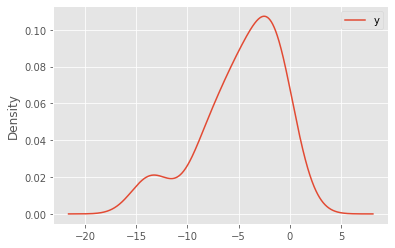

In [11]:
data.plot(kind='kde')

In [12]:
dataset = make_dataset_from_df(data, target_names=['y'], format_features_as='dict')
dataset

<TensorSliceDataset shapes: ((), ()), types: (tf.float32, tf.float32)>

## 2. Define Model

In [13]:
# assumed number of underlying gaussian distributions
max_components = true_component_n

In [14]:
priors = OrderedDict(
    # prior for the weights of the individual gaussians
    weights = tfd.Dirichlet(
        concentration=tf.ones(max_components)
    ),
    # priors for the locations i.e. means of the gaussian components
    loc = tfd.Normal(
        loc=tf.zeros([max_components]),
        scale=tf.ones([max_components])*10.0
    ),
    # priors for the scale i.e. stddev of the gaussian components
    scale = tfd.HalfNormal(
        scale=tf.ones([max_components])*10.0
    )
)

# likelihood defining the gaussian mixture model
def likelihood(weights, loc, scale):
    return tfd.MixtureSameFamily(
        mixture_distribution=tfd.Categorical(probs=weights),
        components_distribution=tfd.Normal(
            loc=loc, 
            scale=scale
        )
    )


In [15]:
# construct model
model = Model(
    priors=priors,
    likelihood=likelihood,
)
model

## 3. Variational Inference

### Various Flow Bijectors

In [16]:
def get_continuous_flow_bijector(unconstrained_event_dims):
    state_fn = tfk.Sequential()
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(unconstrained_event_dims))
    state_fn.build((None, unconstrained_event_dims+1))
    state_time_derivative_fn = lambda t, state: state_fn(tf.concat([tf.fill((state.shape[0],1), t), state], axis=-1))
    return tfb.FFJORD(state_time_derivative_fn, 
                      ode_solve_fn=tfp.math.ode.DormandPrince(first_step_size=0.1).solve, 
                      trace_augmentation_fn=tfb.ffjord.trace_jacobian_hutchinson)
    
def get_hamiltonian_flow_bijector(unconstrained_event_dims, num_flows):
    return tfb.Chain([
        HamiltonianFlow(
            event_dims=unconstrained_event_dims,
            symplectic_integrator=LeapfrogIntegrator(), 
            step_sizes=0.1, 
            num_integration_steps=5,
            hidden_layers=[128, 128]
        ) for _ in range(num_flows)
    ])

def get_masked_autoregressive_flow_bijector(unconstrained_event_dims):
    return tfb.MaskedAutoregressiveFlow(
        shift_and_log_scale_fn=tfb.AutoregressiveNetwork(params=2, hidden_units=[32, 32], activation='relu')
    )

def get_affine_flow_bijector(unconstrained_event_dims):
    return AffineFlow(unconstrained_event_dims)


### Various Surrogate Posteriors

In [17]:
advi = ADVI(model, mean_field=False)

nf = NormalizingFlow(
    model, 
    flow_bijector=get_masked_autoregressive_flow_bijector(model.flat_unconstrained_param_event_ndims)
)
 

### VI fit

In [18]:
vi = VI(model, dataset, surrogate_posterior=advi, 
        discrepancy_fn=tfp.vi.kl_reverse)

In [19]:
NUM_STEPS = 1000
SAMPLE_SIZE = 10
LEARNING_RATE = 1e-2

In [20]:
optimizer = tf.optimizers.Adam(learning_rate=LEARNING_RATE)

In [21]:
%%time
approx_posterior, losses = vi.fit(optimizer=optimizer, num_steps=NUM_STEPS, sample_size=SAMPLE_SIZE)

CPU times: user 4.88 s, sys: 240 ms, total: 5.11 s
Wall time: 4.44 s


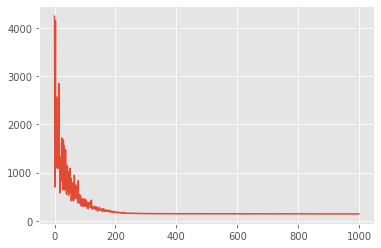

In [22]:
plt.plot(losses)

In [26]:
posterior_samples = approx_posterior.sample(1000)

In [27]:
posterior_samples = OrderedDict([(k, tf.expand_dims(v, axis=1)) for k,v in posterior_samples.items()])

#### Visualize Results

In [28]:
func_dict = {
    "mean": np.mean,
    "stddev": np.std,
    "min": lambda x: np.percentile(x, 0),
    "hdi_3%": lambda x: np.percentile(x, 3),
    "mode": lambda x: np.percentile(x, 50),
    "hdi_97%": lambda x: np.percentile(x, 97),
    "max": lambda x: np.percentile(x, 100)
}

In [29]:
az.summary(
    posterior_samples,
    stat_funcs=func_dict,
    extend=False
)

arviz - WARNING - Shape validation failed: input_shape: (1000, 1), minimum_shape: (chains=1, draws=4)


,mean,stddev,min,hdi_3%,mode,hdi_97%,max
weights[0],0.479,0.162,0.098,0.181,0.472,0.777,0.898
weights[1],0.521,0.162,0.102,0.223,0.528,0.819,0.902
loc[0],-6.994,1.319,-12.220,-9.471,-6.911,-4.636,-2.798
loc[1],-2.594,0.724,-5.046,-3.932,-2.590,-1.290,-0.383
scale[0],4.311,0.756,2.241,2.954,4.344,5.719,6.660
scale[1],1.872,0.587,0.442,0.850,1.853,3.133,3.883


In [30]:
true_component_weights, true_locs, true_scales

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.48, 0.52], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-8., -2.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 2.], dtype=float32)>)

array([[<AxesSubplot:title={'center':'weights\n0'}>,
        <AxesSubplot:title={'center':'weights\n1'}>,
        <AxesSubplot:title={'center':'loc\n0'}>],
       [<AxesSubplot:title={'center':'loc\n1'}>,
        <AxesSubplot:title={'center':'scale\n0'}>,
        <AxesSubplot:title={'center':'scale\n1'}>]], dtype=object)

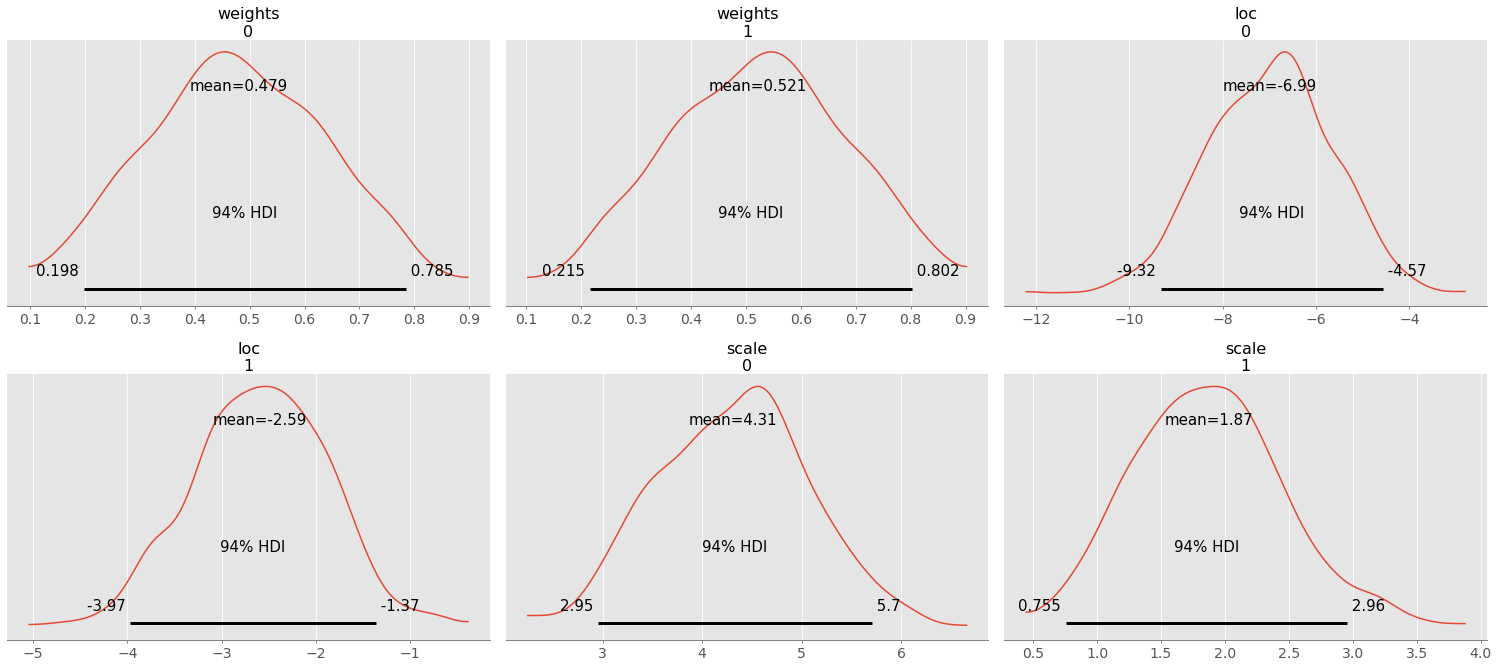

In [31]:
az.plot_posterior(posterior_samples, round_to=3)

## MCMC

In [32]:
# sampling params
NUM_CHAINS = 4
NUM_SAMPLES = 1000
NUM_BURNIN_STEPS = 100

In [36]:
# define step size adaptation
step_size_adaptation_kernel = DualAveragingStepSizeAdaptation(num_adaptation_steps=int(NUM_BURNIN_STEPS*0.8))
#step_size_adaptation_kernel = None

# define Markov Transition Kernel
#kernel = HamiltonianMonteCarlo(step_size=0.01, num_leapfrog_steps=100)
kernel = NoUTurnSampler(step_size=0.01, max_tree_depth=5, stepsize_adaptation_kernel=step_size_adaptation_kernel)
#kernel = RandomWalkMetropolis()

In [37]:
# define inference object (model, data, bijectors)
mcmc = MCMC(model=model, dataset=dataset, transition_kernel=kernel)

#### MCMC fit

In [39]:
# use mcmc with defined kernel and sample
result = mcmc.fit(
    num_chains=NUM_CHAINS, 
    num_samples=NUM_SAMPLES, 
    num_burnin_steps=NUM_BURNIN_STEPS, 
)

#### Visualize Results


In [40]:
print('Acceptance ratios per chain: {}'.format(result.accept_ratios))

Acceptance ratios per chain: [0.989 0.983 0.924 0.98 ]


In [41]:
posterior_samples = OrderedDict([(k, np.swapaxes(v.numpy(), 0,1)) for k, v in zip(model.param_names, result.samples)])

In [42]:
true_component_weights, true_locs, true_scales

(<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.48, 0.52], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-8., -2.], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([4., 2.], dtype=float32)>)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
weights[0],0.50,0.25,0.08,0.93,0.05,0.04,21.28,21.28,21.89,93.42,1.13
weights[1],0.50,0.25,0.07,0.92,0.05,0.04,21.28,21.28,21.89,93.42,1.13
loc[0],-5.49,3.77,-13.58,-1.34,1.27,0.93,8.80,8.80,9.67,124.00,1.34
loc[1],-6.02,3.46,-13.41,-1.23,1.13,0.83,9.35,9.35,9.23,52.12,1.36
scale[0],3.01,2.09,0.54,5.55,0.22,0.16,89.44,89.44,38.81,289.10,1.10
scale[1],3.20,1.56,0.07,5.58,0.34,0.24,21.31,21.31,21.15,116.16,1.13


array([[<AxesSubplot:title={'center':'weights\n0'}>,
        <AxesSubplot:title={'center':'weights\n1'}>,
        <AxesSubplot:title={'center':'loc\n0'}>],
       [<AxesSubplot:title={'center':'loc\n1'}>,
        <AxesSubplot:title={'center':'scale\n0'}>,
        <AxesSubplot:title={'center':'scale\n1'}>]], dtype=object)

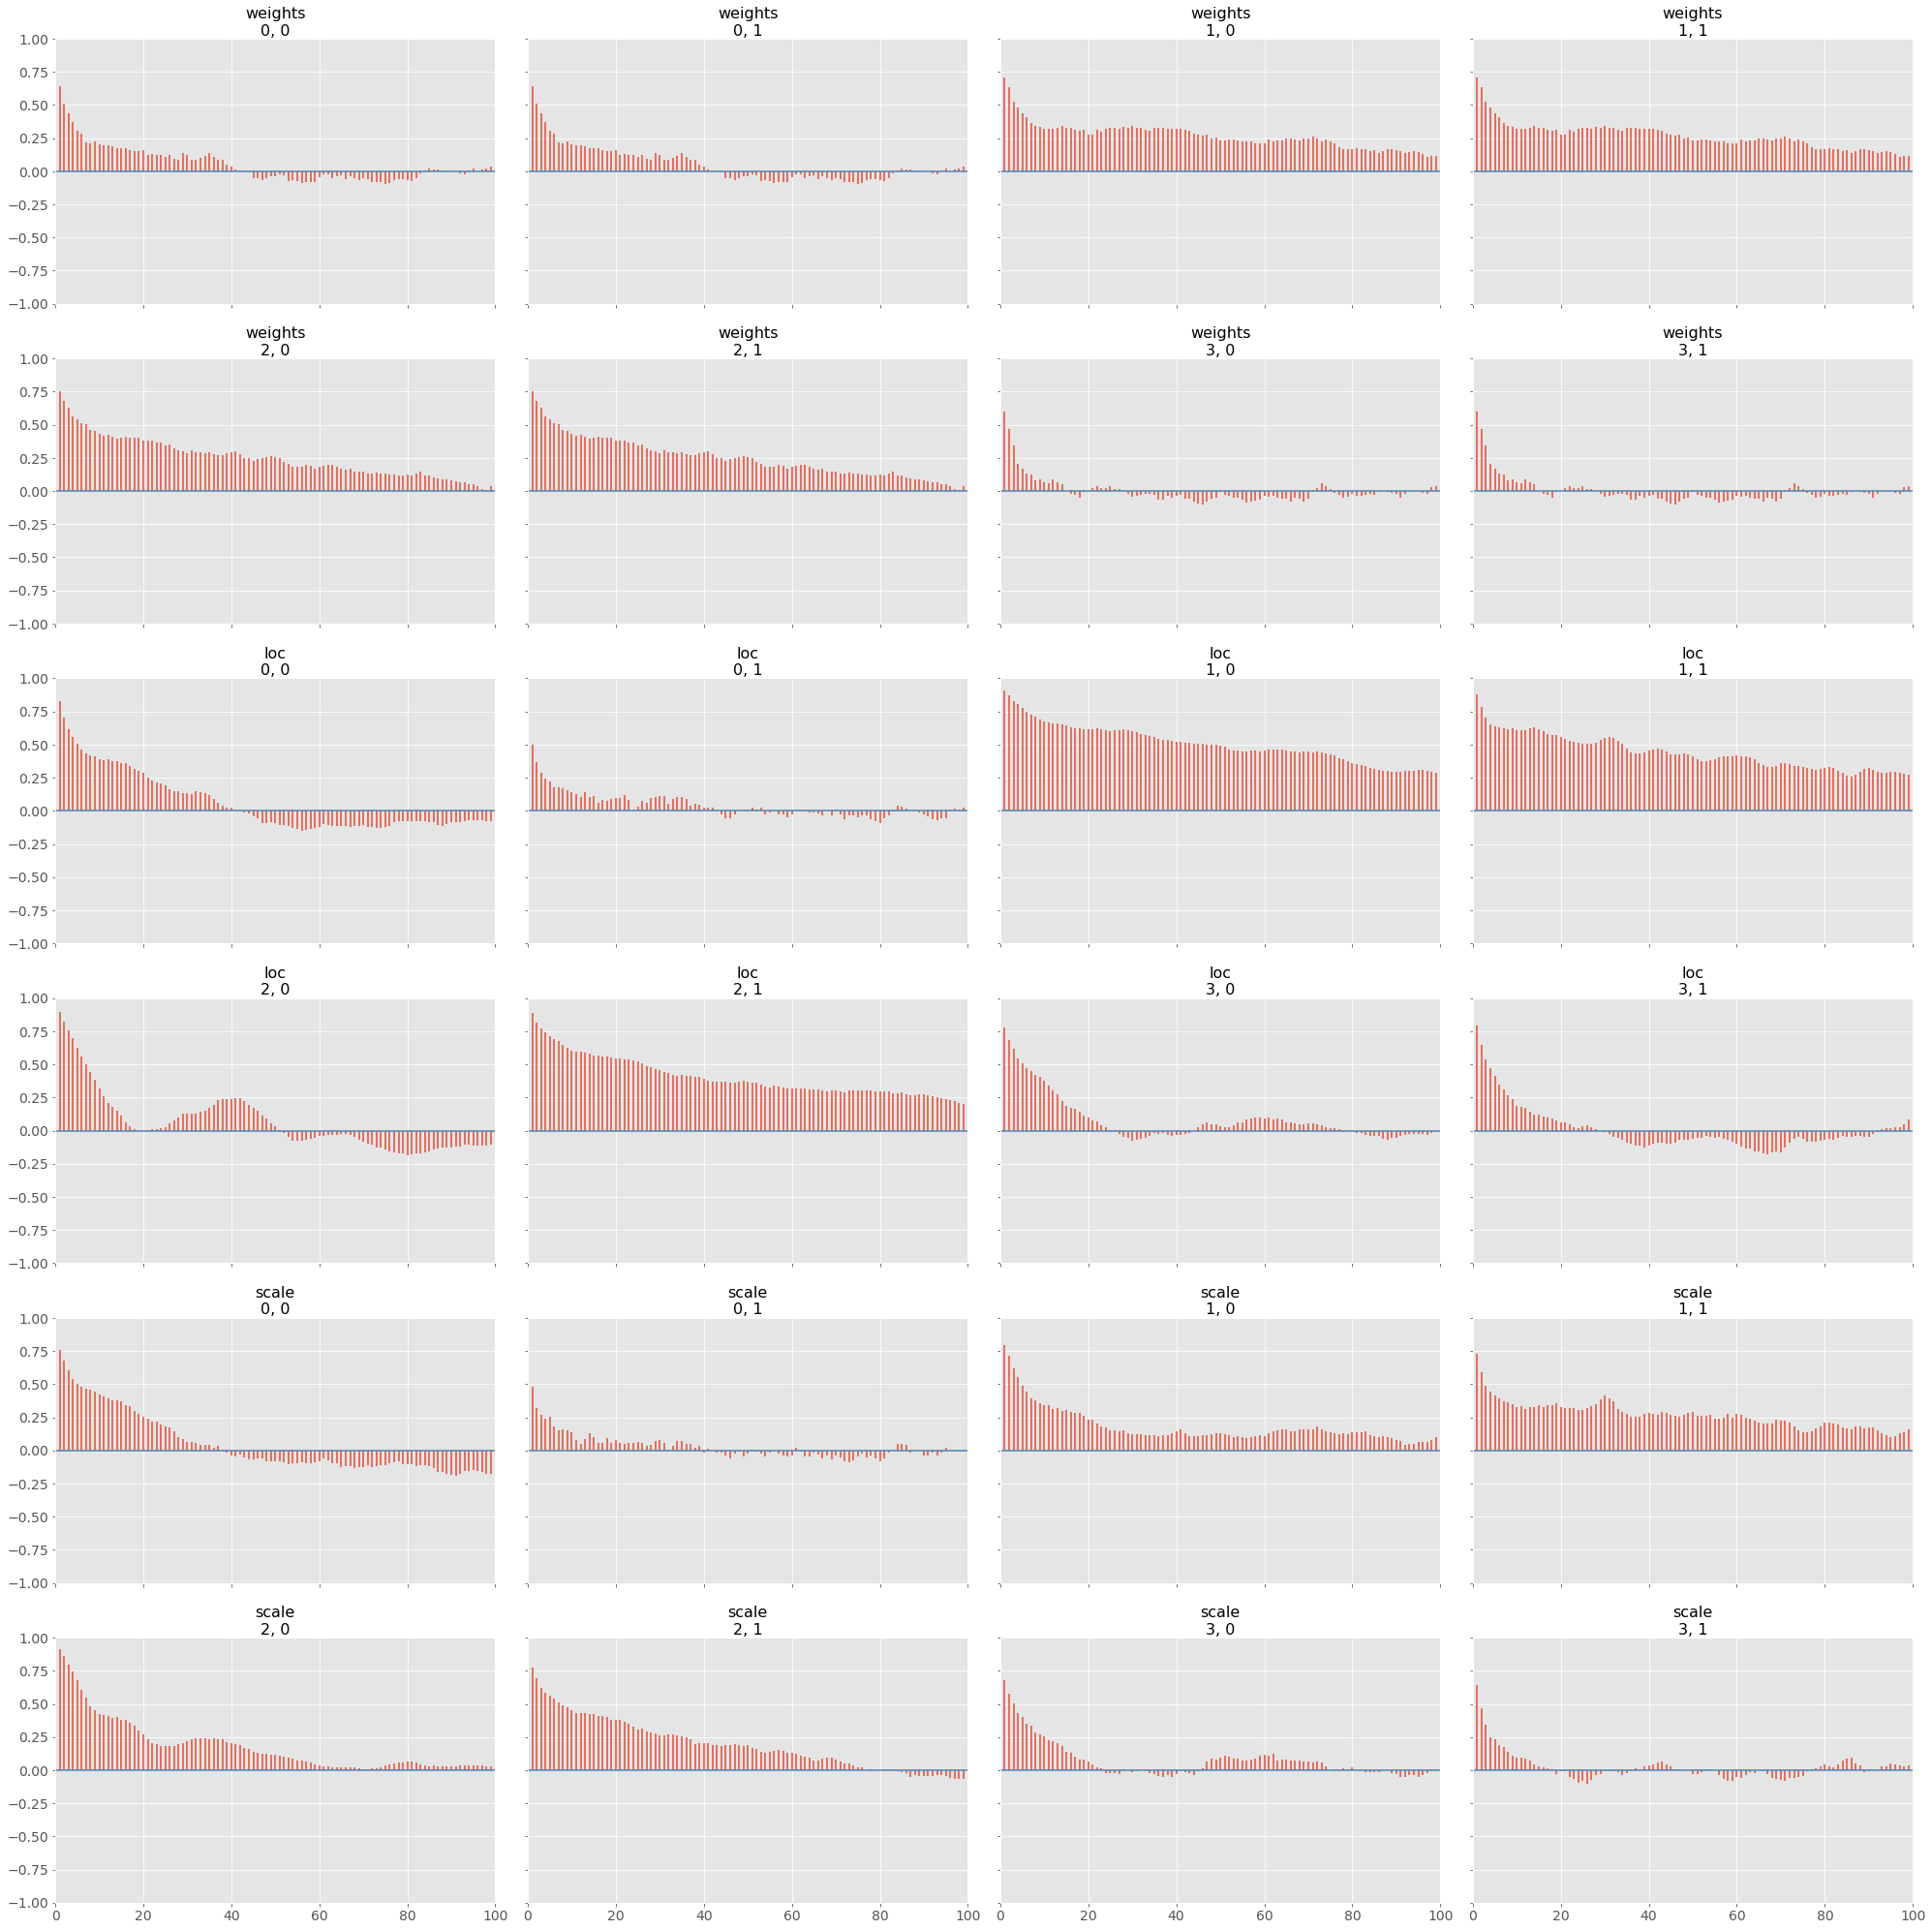

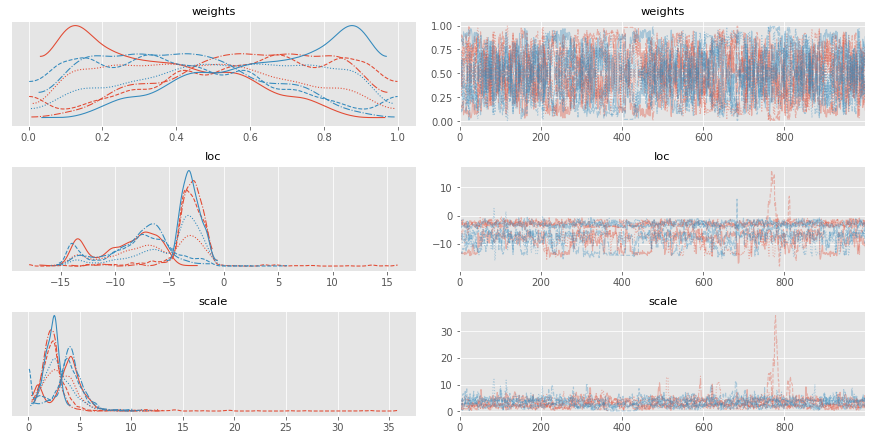

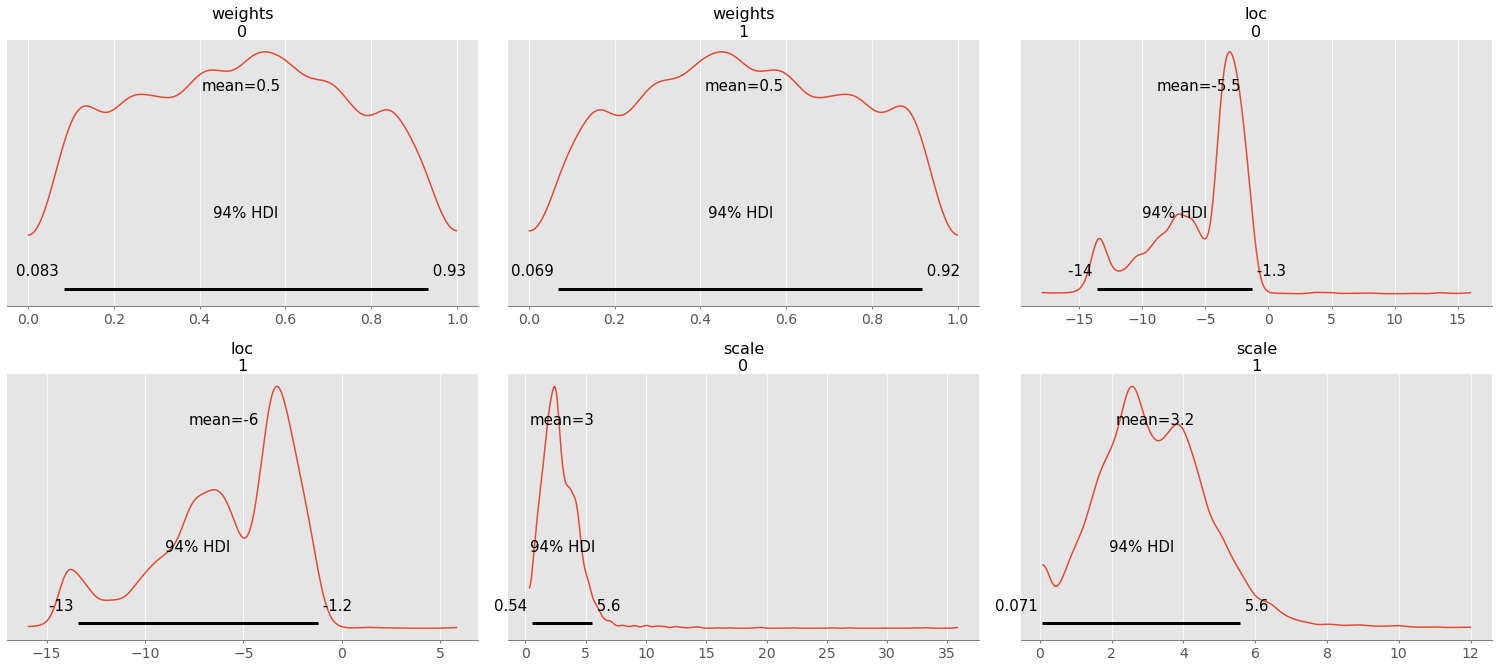

In [43]:
display(az.summary(posterior_samples, round_to=2))
az.plot_autocorr(posterior_samples)
az.plot_trace(posterior_samples)
az.plot_posterior(posterior_samples)